In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
import seaborn as sb

# Lecture des données: Prepocessing, nettoyage et formatage des données

In [94]:
#### Lecture des données sources à partir des fichiers Excel
df_excence=pd.read_excel("Data/excence.xlsx")
df_elec=pd.read_excel("Data/elec_v2.xlsx")
df_personne = pd.read_excel("Data/Personna_circo.xlsx")

C:\Users\thabet.chaaouri\.virtualenvs\ElectionsFTV-WiexROcB\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [95]:
#### formatage code circo pour les personnalité natio suivant le format "0 + code dépa + _ + code circo"
position = -3
character="_"
df_personne.Circo= df_personne.Circo.map(lambda x :  "0"+str(x)[:position] + character + str(x)[position+1:]  if (len(str(x)) == 5) else 
                                                 "00"+str(x)[:position] + character + str(x)[position+1:] )

In [96]:
#Jointure des données Elec et Excense en se basant sur les codes Lieu
df_elec_excence=pd.merge(df_elec, df_excence, left_on="LIEU", right_on="Name", how="inner")
# Fotmatage des types de données en datetime
df_elec_excence["Date première saisie"] = pd.to_datetime(df_elec_excence["Date première saisie"])
df_elec_excence["Date dernière saisie"] = pd.to_datetime(df_elec_excence["Date dernière saisie"])
df_elec_excence["Date première saisie excense"] = pd.to_datetime(df_elec_excence["Value"])
#gestion des timezone
df_elec_excence["Date première saisie excense"] = df_elec_excence["Date première saisie excense"] + pd.Timedelta(hours=2)
df_elec_excence["Date première saisie excense"] =df_elec_excence["Date première saisie excense"] .apply(lambda x: x.replace(tzinfo=None))
df_elec_excence=df_elec_excence.drop(["Value","PREM_GMT_TIME", "Name"], axis=1)

In [97]:
#Calcul du delta Elec Excense en heures puis en minutes
df_elec_excence["delta_saisie"]=df_elec_excence["Date première saisie excense"]-df_elec_excence["Date première saisie"]
df_elec_excence["delta en minutes"] =df_elec_excence["delta_saisie"].dt.total_seconds()/60
# Eliminer les outre mers
df_elec_excence = df_elec_excence.drop(df_elec_excence[~df_elec_excence.LIEU.str.startswith("0")].index) 

##### Voici un aperçu des données à traiter: les outre mers sont écartés

In [98]:
df_elec_excence.head()

,LIEU,Date première saisie,Date dernière saisie,Source,REDACTION,Date première saisie excense,delta_saisie,delta en minutes
0,059_17,2022-06-19 20:25:13,2022-06-19 20:25:13,ELECPLUS,LILLE,2022-06-19 21:40:23,0 days 01:15:10,75.166667
1,013_04,2022-06-19 23:24:44,2022-06-19 23:24:44,ELECPLUS,MARSEILLE,2022-06-19 23:21:20,-1 days +23:56:36,-3.400000
2,013_14,2022-06-19 20:51:14,2022-06-19 20:51:14,ELECPLUS,MARSEILLE,2022-06-19 23:25:12,0 days 02:33:58,153.966667
3,063_03,2022-06-19 21:07:04,2022-06-19 21:07:04,ELECPLUS,CLERMONT,2022-06-19 21:05:24,-1 days +23:58:20,-1.666667
4,093_06,2022-06-19 23:11:44,2022-06-19 23:11:44,ELECPLUS,VANVES,2022-06-19 23:04:46,-1 days +23:53:02,-6.966667


# Visualisation des données

### Graphiques optionnelles : 

#### <font color='red'>Répartition des circo par source de saisie dans Elec+</font>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


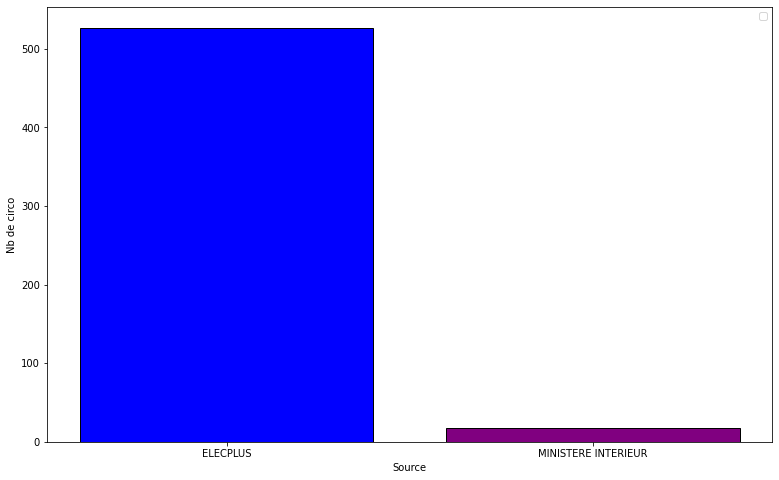

In [99]:
plt.rcParams['figure.figsize'] = [13, 8]
fig, ax =plt.subplots()
df_source=df_elec_excence.groupby("Source").count().reset_index()
ax.bar(df_source["Source"], df_source["LIEU"],color=["blue", "purple"], edgecolor="k")
ax.set_xlabel("Source")
ax.set_ylabel("Nb de circo")
ax.legend();
#df_source

#### <font color='red'>Répartition des circo remontées par le ministère par rédaction</font>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


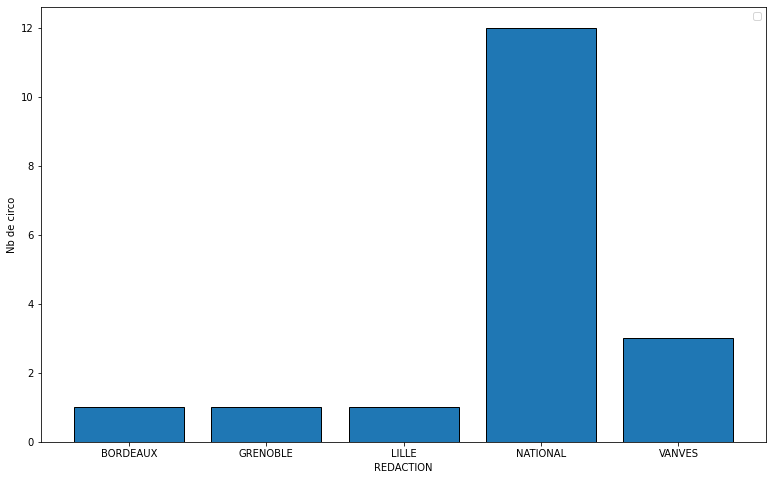

In [100]:
df_elec_minstr=df_elec_excence.loc[df_elec_excence.Source == "MINISTERE INTERIEUR"]
fig, ax =plt.subplots()
df_source=df_elec_minstr.groupby("REDACTION").count().reset_index()
ax.bar(df_source["REDACTION"], df_source["LIEU"], edgecolor="k")
ax.set_xlabel("REDACTION")
ax.set_ylabel("Nb de circo")
ax.legend();
#df_source

### Graphiques comparaison Elec vs Excense : 

#### <font color='red'>Chiffres clés à retenir du delta = Excense - Elec</font>

In [14]:
stats_describe=df_elec_excence.describe()
stats_describe

,delta_saisie,delta en minutes
count,545,545.000000
mean,0 days 00:18:53.311926605,18.888532
std,0 days 00:28:21.654920569,28.360915
min,-1 days +23:19:57,-40.050000
25%,0 days 00:01:43,1.716667
50%,0 days 00:11:29,11.483333
75%,0 days 00:27:00,27.000000
max,0 days 02:52:44,172.733333


#### <font color='red'>Distribution des nb de circo par delta (illustartion avec les quantiles)</font>

C:\Users\thabet.chaaouri\.virtualenvs\ElectionsFTV-WiexROcB\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


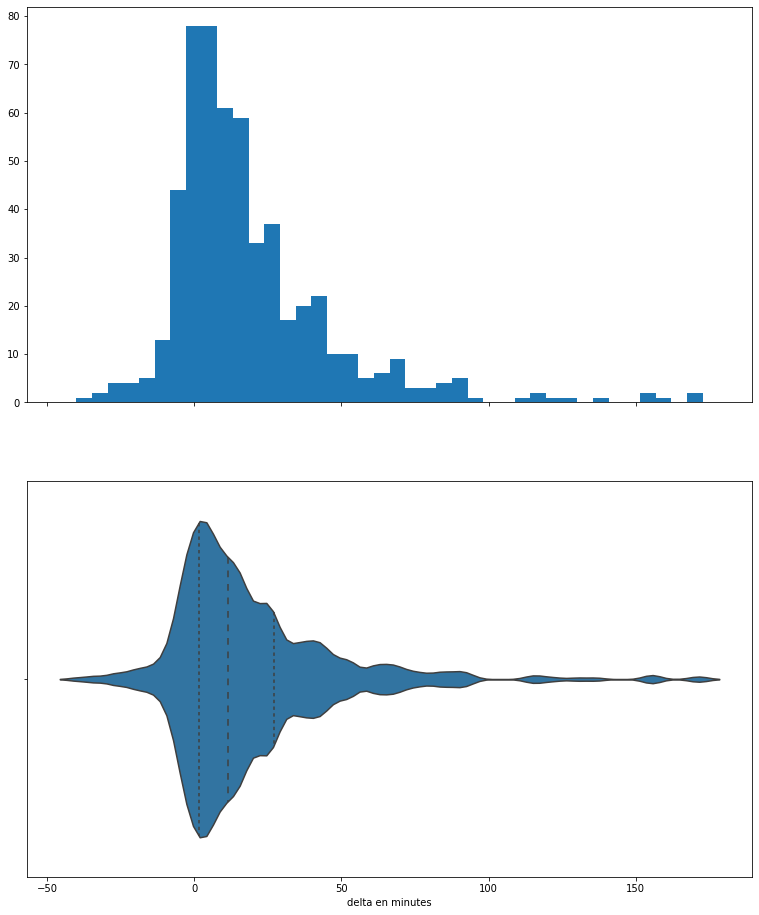

In [109]:
f, (ax_hist,ax_box) = plt.subplots(2, sharex=True, figsize=(13,16))
sb.violinplot(df_elec_excence["delta en minutes"], inner="quartile",bw=0.1, ax= ax_box);
ax_hist.hist(df_elec_excence["delta en minutes"], bins=40, label="distribution de la différence de saisie (Excense -Elec+) en mm");
ax.legend();

#### <font color='red'>Evolution des nb de circo en fonction du temps</font>

In [17]:
first_sais_elec=pd.DataFrame(df_elec_excence.resample('10T', on="Date première saisie").LIEU.count().cumsum()).reset_index()
first_sais_exce=pd.DataFrame(df_elec_excence.resample('10T', on="Date première saisie excense").LIEU.count().cumsum()).reset_index()
Compa_firstsaisie=pd.merge(first_sais_elec,first_sais_exce, left_on="Date première saisie", right_on="Date première saisie excense", how="outer" )

In [18]:
Compa_firstsaisie=Compa_firstsaisie.drop("Date première saisie excense", axis=1)

Compa_firstsaisie.rename({"LIEU_x":"nb_circo_elec",
                          "LIEU_y":"nb_circo_excense"},axis=1, inplace=True)

In [19]:
Compa_firstsaisie=Compa_firstsaisie.set_index(["Date première saisie"])

In [20]:
start, end = first_sais_elec["Date première saisie"].min() , first_sais_exce["Date première saisie excense"].max()
new_index = pd.date_range(start, end, freq="10T") 

In [21]:
Compa_firstsaisie.index=new_index
Compa_firstsaisie.nb_circo_elec=Compa_firstsaisie.nb_circo_elec.ffill()
Compa_firstsaisie.nb_circo_excense=Compa_firstsaisie.nb_circo_excense.fillna(0)

In [22]:
Compa_firstsaisie["delta_nb_circo"]=Compa_firstsaisie.nb_circo_elec-Compa_firstsaisie.nb_circo_excense

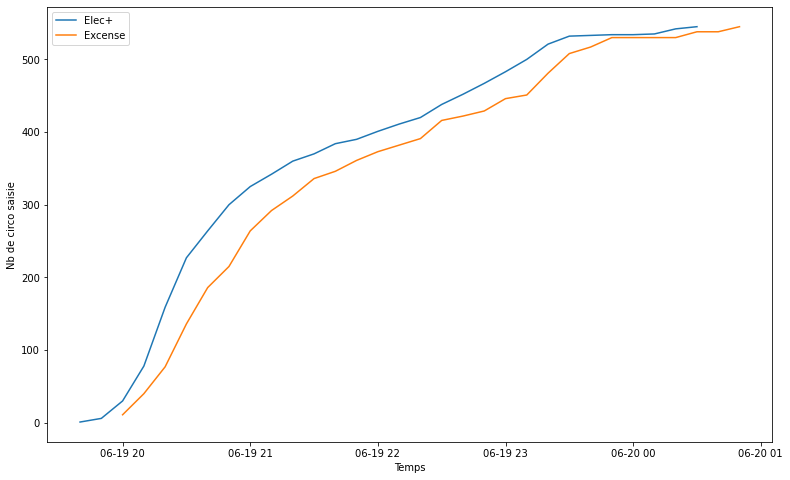

In [23]:
fig, ax =plt.subplots()
ax.plot(first_sais_elec["Date première saisie"],first_sais_elec["LIEU"], label="Elec+")
ax.plot(first_sais_exce["Date première saisie excense"],first_sais_exce["LIEU"], label="Excense")
ax.set_xlabel("Temps")
ax.set_ylabel("Nb de circo saisie")
ax.legend();

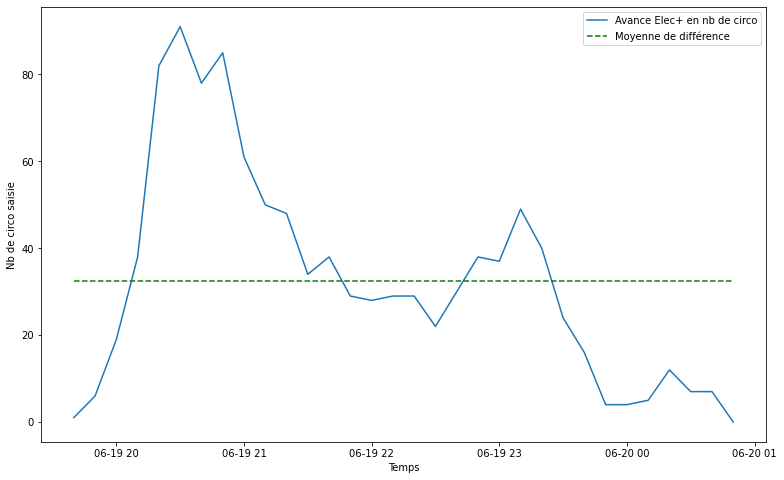

In [24]:
fig, ax =plt.subplots()
ax.plot(Compa_firstsaisie.index, Compa_firstsaisie.delta_nb_circo, label="Avance Elec+ en nb de circo")
ax.plot(Compa_firstsaisie.index,[Compa_firstsaisie.delta_nb_circo.mean()]*len(Compa_firstsaisie.index), label='Moyenne de différence',
        linestyle='--', color="green")
ax.set_xlabel("Temps")
ax.set_ylabel("Nb de circo saisie")
ax.legend();

In [25]:
def build_cumsum_circo(antenne):
    df_antenne=df_elec_excence.loc[df_elec_excence.REDACTION==antenne]
    first_sais_antenne_elec=pd.DataFrame(df_antenne.resample('10T', on="Date première saisie").LIEU.count().cumsum()).reset_index()
    first_sais_antenne_exce=pd.DataFrame(df_antenne.resample('10T', on="Date première saisie excense").LIEU.count().cumsum()).reset_index()
    Compa_firstsaisie_antenne=pd.merge(first_sais_antenne_elec,first_sais_antenne_exce, left_on="Date première saisie", right_on="Date première saisie excense", 
                           how="outer" )
    Compa_firstsaisie_antenne=Compa_firstsaisie_antenne.drop("Date première saisie excense", axis=1)
    Compa_firstsaisie_antenne.rename({"LIEU_x":"nb_circo_elec",
                          "LIEU_y":"nb_circo_excense"},axis=1, inplace=True)
    start, end = first_sais_antenne_elec["Date première saisie"].min() , first_sais_antenne_exce["Date première saisie excense"].max()
    new_index = pd.date_range(start, end, freq="10T")
    Compa_firstsaisie_antenne.index=new_index
    Compa_firstsaisie_antenne=Compa_firstsaisie_antenne.drop("Date première saisie", axis=1)
    Compa_firstsaisie_antenne.nb_circo_elec=Compa_firstsaisie_antenne.nb_circo_elec.ffill()
    Compa_firstsaisie_antenne.nb_circo_excense=Compa_firstsaisie_antenne.nb_circo_excense.fillna(0)
    Compa_firstsaisie_antenne["delta_nb_circo"]=Compa_firstsaisie_antenne.nb_circo_elec-Compa_firstsaisie_antenne.nb_circo_excense
    return Compa_firstsaisie_antenne
    
    

# Focus Ile de France

In [26]:
df_idf=df_elec_excence.loc[df_elec_excence.REDACTION=="VANVES"]

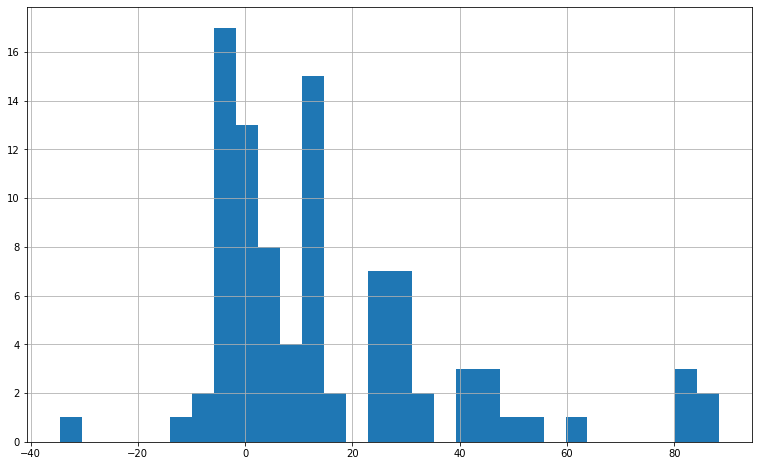

In [27]:
df_idf["delta en minutes"].hist(bins=30);

C:\Users\thabet.chaaouri\.virtualenvs\ElectionsFTV-WiexROcB\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


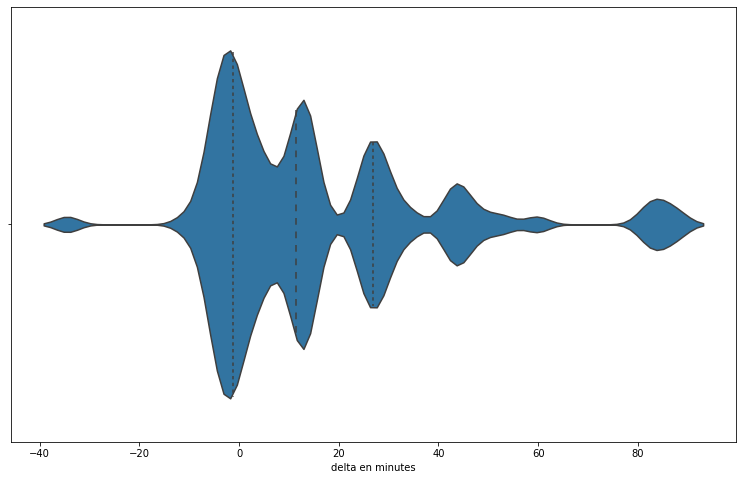

In [28]:
sb.violinplot(df_idf["delta en minutes"], inner="quartile",bw=0.1);

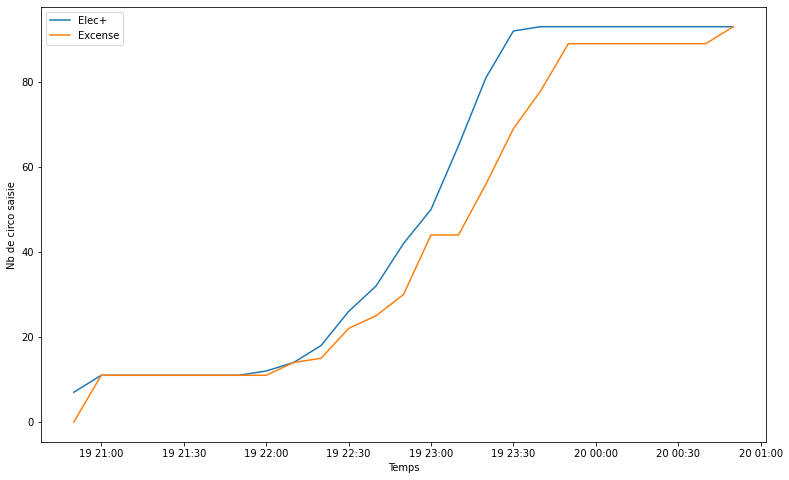

In [29]:
Compa_firstsaisie_idf=build_cumsum_circo("VANVES")

fig, ax =plt.subplots()
ax.plot(Compa_firstsaisie_idf.index,Compa_firstsaisie_idf.nb_circo_elec, label="Elec+")
ax.plot(Compa_firstsaisie_idf.index,Compa_firstsaisie_idf.nb_circo_excense, label="Excense")
ax.set_xlabel("Temps")
ax.set_ylabel("Nb de circo saisie")
ax.legend();

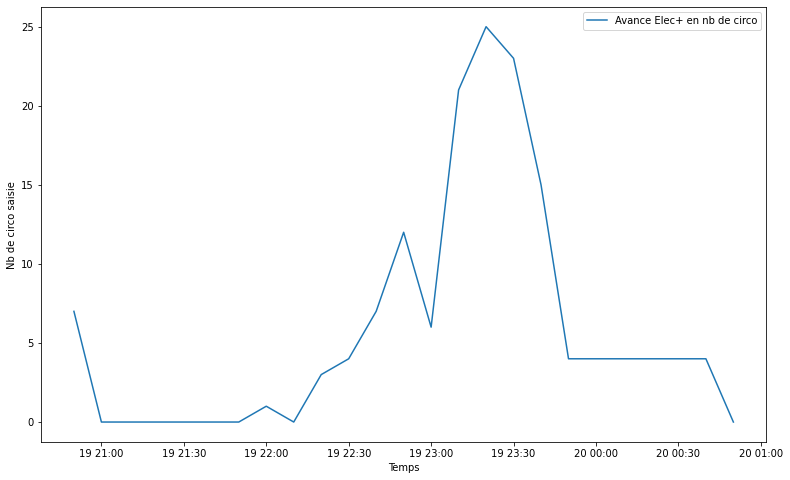

In [30]:
fig, ax =plt.subplots()
ax.plot(Compa_firstsaisie_idf.index, Compa_firstsaisie_idf.delta_nb_circo, label="Avance Elec+ en nb de circo")
ax.set_xlabel("Temps")
ax.set_ylabel("Nb de circo saisie")
ax.legend();

# Focus Marseille

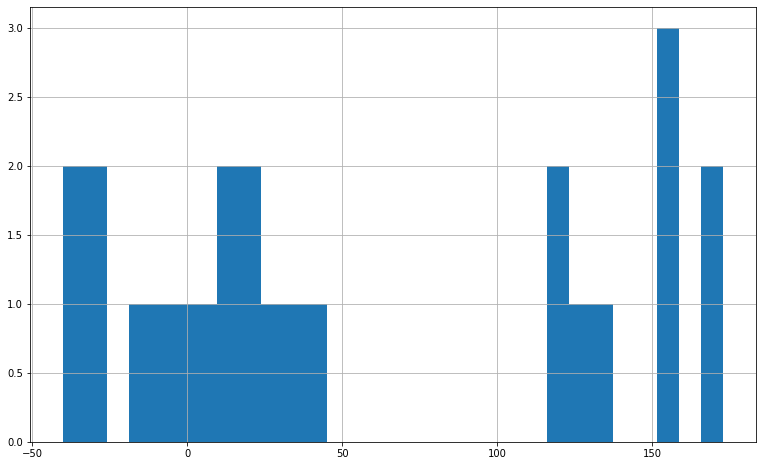

In [31]:
df_marseille=df_elec_excence.loc[df_elec_excence.REDACTION=="MARSEILLE"]
df_marseille["delta en minutes"].hist(bins=30);

C:\Users\thabet.chaaouri\.virtualenvs\ElectionsFTV-WiexROcB\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


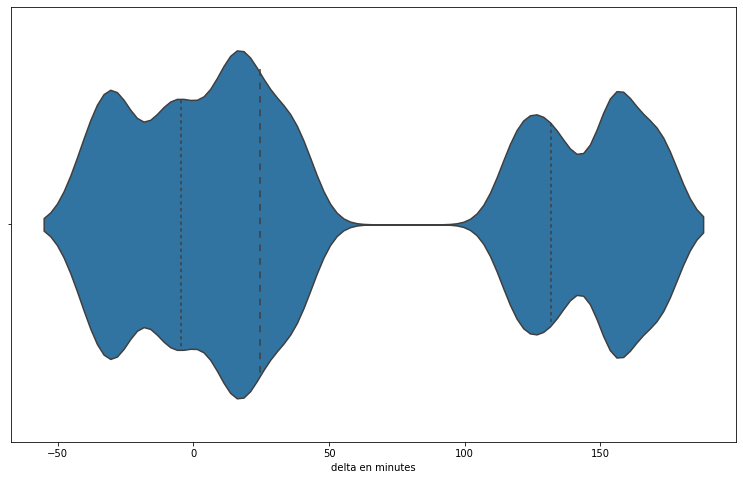

In [32]:
sb.violinplot(df_marseille["delta en minutes"], inner="quartile",bw=0.1);

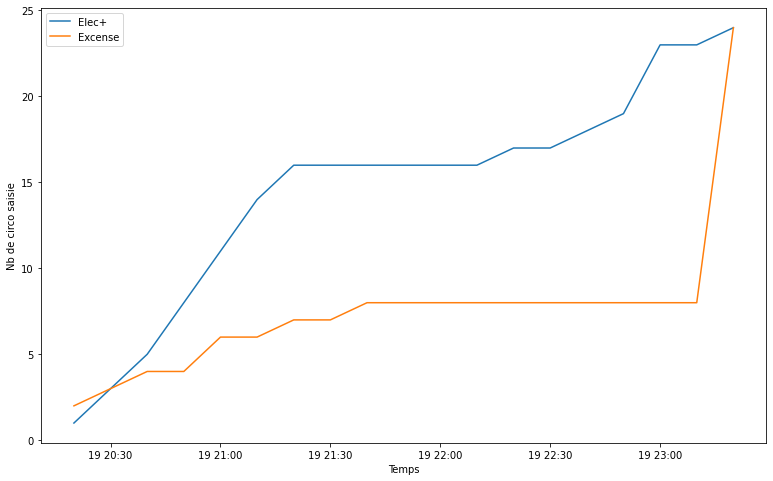

In [33]:
Compa_firstsaisie_marseille=build_cumsum_circo("MARSEILLE")

fig, ax =plt.subplots()
ax.plot(Compa_firstsaisie_marseille.index,Compa_firstsaisie_marseille.nb_circo_elec, label="Elec+")
ax.plot(Compa_firstsaisie_marseille.index,Compa_firstsaisie_marseille.nb_circo_excense, label="Excense")
ax.set_xlabel("Temps")
ax.set_ylabel("Nb de circo saisie")
ax.legend();

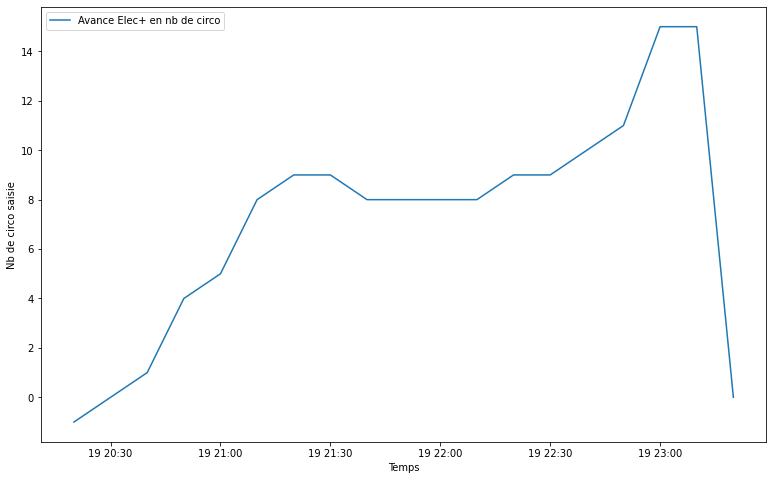

In [34]:
fig, ax =plt.subplots()
ax.plot(Compa_firstsaisie_marseille.index, Compa_firstsaisie_marseille.delta_nb_circo, label="Avance Elec+ en nb de circo")
ax.set_xlabel("Temps")
ax.set_ylabel("Nb de circo saisie")
ax.legend();

# Overview antennes

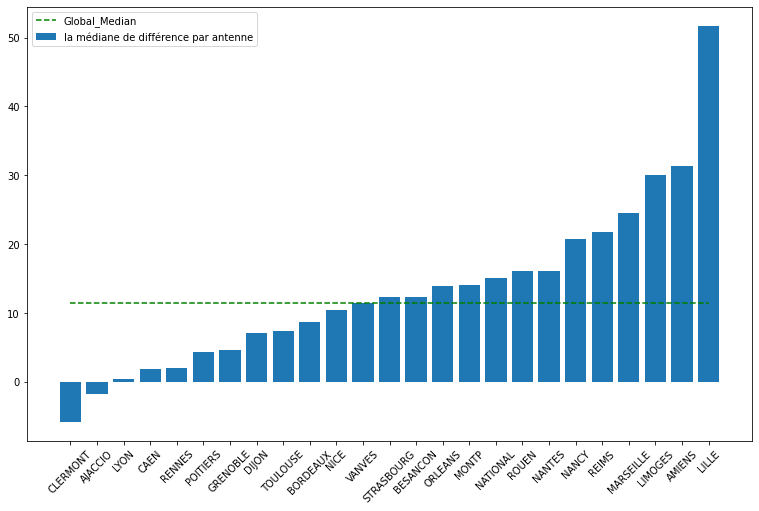

In [110]:
df_all_antennes=df_elec_excence.groupby("REDACTION").median().reset_index().sort_values("delta en minutes")
fig, ax =plt.subplots()

ax.bar(df_all_antennes["REDACTION"],df_all_antennes["delta en minutes"], label="la médiane de différence par antenne")
plt.xticks(rotation=45)
ax.plot(df_all_antennes["REDACTION"],[stats_describe.loc["50%","delta en minutes"]]*len(df_all_antennes["REDACTION"]), label='Global_Median',
        linestyle='--', color="green")
ax.legend();
#df_all_antennes.plot(x="REDACTION",y=11, label='Mean', linestyle='--')

# Personnalités publiques

In [36]:
df_res_pers=pd.merge(df_elec_excence, df_personne, left_on="LIEU", right_on="Circo", how="inner")

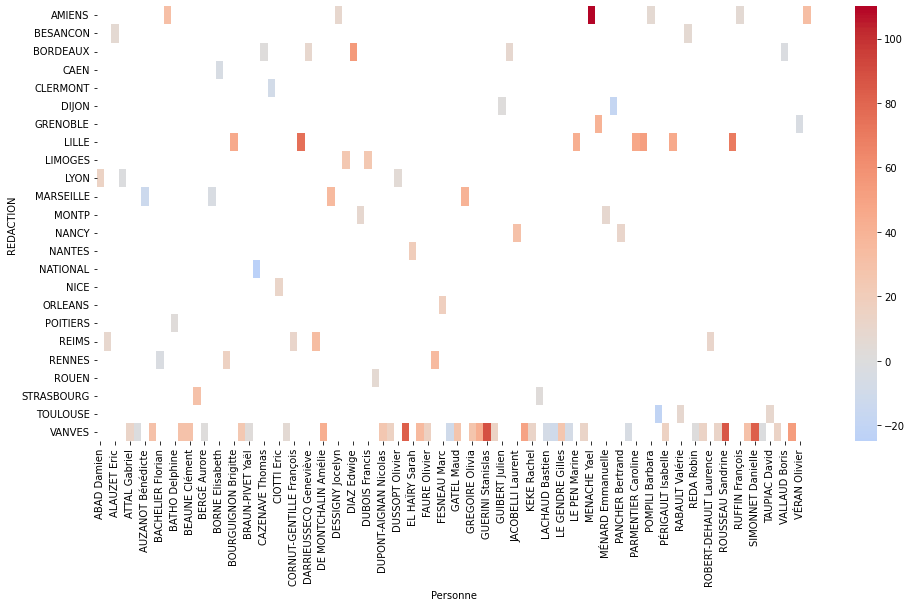

In [37]:
df_matr = df_res_pers.set_index(["REDACTION", "Personne"])
df_matr =df_matr.sort_index()
df_heat=df_matr["delta en minutes"].unstack()
fig, ax=plt.subplots(figsize=(16,8))
sb.heatmap(data=df_heat ,  cmap='coolwarm', ax=ax, center=0, vmin=-25, vmax=110);

In [56]:
df_pers_exce=df_res_pers.loc[df_res_pers["delta en minutes"]<0].sort_values("delta en minutes")
df_pers_0_20=df_res_pers.loc[df_res_pers["delta en minutes"]>20].sort_values("delta en minutes")
df_pers_elec=df_res_pers.loc[(df_res_pers["delta en minutes"]>0) & (df_res_pers["delta en minutes"]<20)].sort_values("delta en minutes")

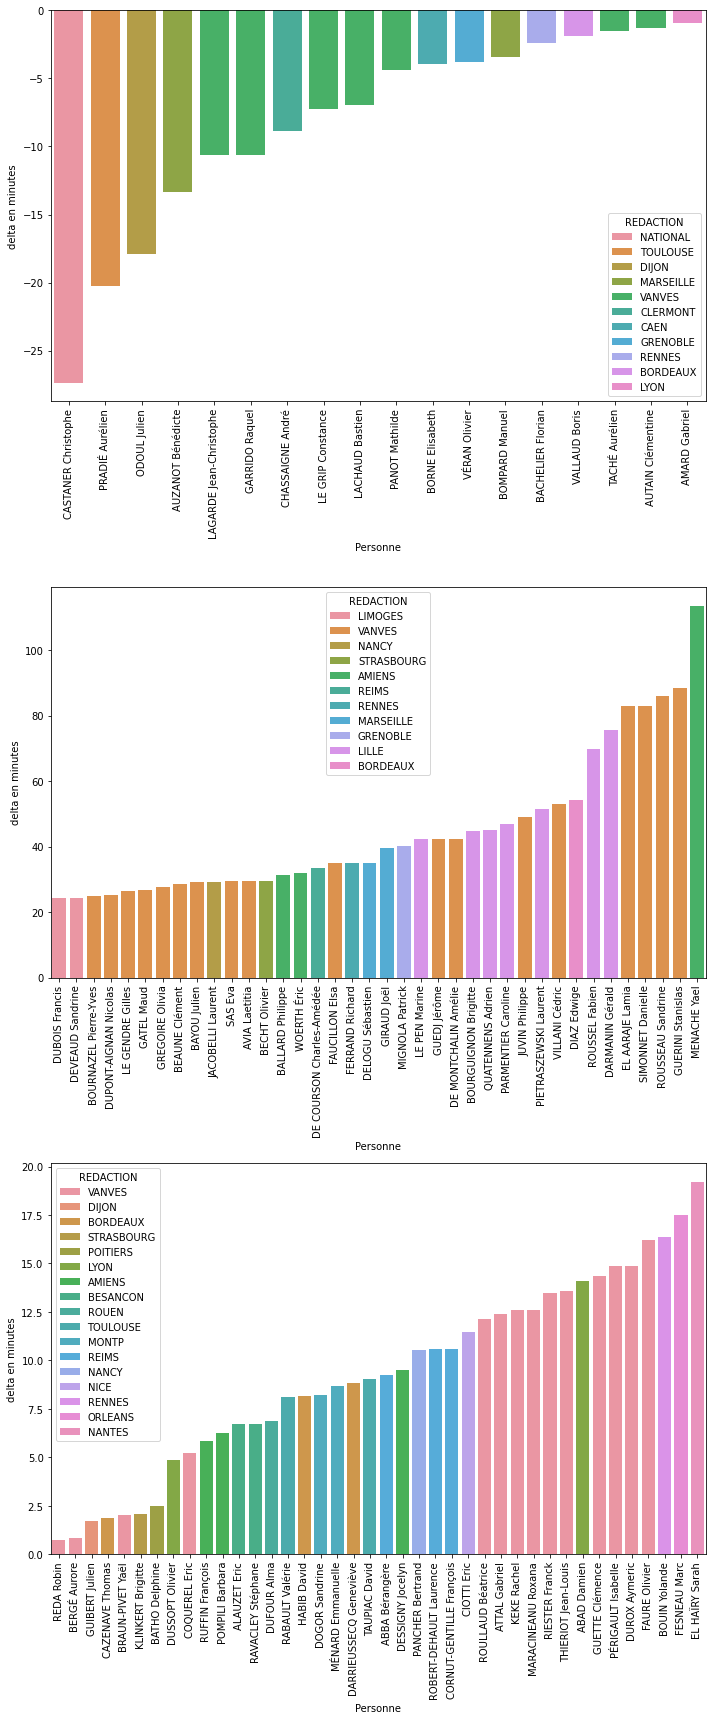

In [89]:
fig, axes=plt.subplots(3, figsize=(10,24))

sb.barplot(x=df_pers_exce.Personne, y = df_pers_exce["delta en minutes"], hue=df_pers_exce.REDACTION, dodge=False, ax = axes[0]);
axes[0].set_xticklabels(list(df_pers_exce.Personne), rotation=90);

sb.barplot(x=df_pers_0_20.Personne, y = df_pers_0_20["delta en minutes"],  hue=df_pers_0_20.REDACTION, dodge=False, ax = axes[1]);
axes[1].set_xticklabels(list(df_pers_0_20.Personne), rotation=90);

sb.barplot(x=df_pers_elec.Personne, y = df_pers_elec["delta en minutes"],  hue=df_pers_elec.REDACTION,dodge=False, ax = axes[2]);
axes[2].set_xticklabels(list(df_pers_elec.Personne), rotation=90);

fig.tight_layout()
plt.show()

C:\Users\thabet.chaaouri\.virtualenvs\ElectionsFTV-WiexROcB\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


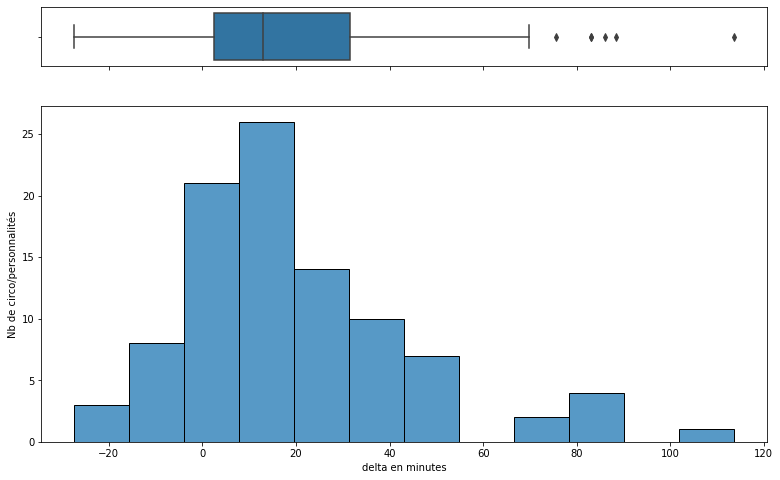

In [92]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sb.boxplot(df_res_pers["delta en minutes"], ax=ax_box)
sb.histplot(data=df_res_pers, x="delta en minutes", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set_ylabel("Nb de circo/personnalités")
plt.show()